#### Imports & Downloads

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn import metrics

from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import LinearSVC

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

from sklearn.model_selection import cross_val_score

from src.functions.vectorize_functions import vectorize_tfidf, vectorize_glove, vectorize_w2v

### Model Preparation

#### Functions

In [2]:
def print_target_distribution(df, colname):
    positive = np.count_nonzero(df[colname] == 1)
    negative = np.count_nonzero(df[colname] == 0)
    print("- Positive:", positive)
    print("- Negative:", negative)
    print("- Verhältnis:", negative / positive)

In [3]:
evaluation = pd.DataFrame(
    columns=["model", "tuning", "vec_variant", "train_acc", "train_prec", "train_rec", "train_f1", "test_acc",
             "test_prec",
             "test_rec", "test_f1"])

In [4]:
def add_to_eval_df(model, model_name, tuning, vec_variant, x_data_train, y_data_train, x_data_test, y_data_test):
    train_acc = model.score(x_data_train, y_data_train)
    train_precision = precision_score(y_data_train, model.predict(x_data_train))
    train_recall = recall_score(y_data_train, model.predict(x_data_train))
    train_f1 = f1_score(y_data_train, model.predict(x_data_train))

    test_acc = model.score(x_data_test, y_data_test)
    test_precision = precision_score(y_data_test, model.predict(x_data_test))
    test_recall = recall_score(y_data_test, model.predict(x_data_test))
    test_f1 = f1_score(y_data_test, model.predict(x_data_test))

    evaluation.loc[len(evaluation.index)] = [model_name, tuning, vec_variant, train_acc, train_precision, train_recall,
                                             train_f1,
                                             test_acc, test_precision, test_recall, test_f1]

In [5]:
def evaluate_model(model, x_test, y_test):
    pred = model.predict(x_test)
    accscore = metrics.accuracy_score(pred, y_test)

    print(f'model accuracy for classification is =', str('{:04.2f}'.format(accscore * 100)) + '%')
    print('------------------------------------------------')
    print('Confusion Matrix:')
    print(pd.DataFrame(confusion_matrix(y_test, pred)))
    print('------------------------------------------------')
    print('Classification Report:')
    print(classification_report(y_test, pred))

    probs = model.predict_proba(x_test)
    preds = probs[:, 1]
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()


#### Data Import

In [6]:
df_train_cleaned = pd.read_csv("..\\..\\..\\data\\new_datasets\\train_cleaned_rnn.csv")

In [7]:
print_target_distribution(df_train_cleaned, 'label')

- Positive: 13428
- Negative: 49581
- Verhältnis: 3.692359249329759


In [8]:
df_train_cleaned = df_train_cleaned[df_train_cleaned.tweet_cleaned.notna()]
df_train_cleaned.isna().sum()

Unnamed: 0           0
tweet                0
label                0
tweet_cleaned        0
user_handle          0
hashtags             0
emojis           59905
dtype: int64

#### Vectorize - Word2Vec

In [9]:
X_train_w2v, X_test_w2v, y_train_w2v, y_test_w2v = vectorize_w2v(df=df_train_cleaned,
                                                                 text_column="tweet_cleaned",
                                                                 label_column="label")

#### Vectorize - TF-IDF

In [10]:
X_train_tf, X_test_tf, y_train_tf, y_test_tf = vectorize_tfidf(df=df_train_cleaned,
                                                               text_column="tweet_cleaned",
                                                               label_column="label")

#### Vectorize - Glove

In [11]:
X_train_gl, X_test_gl, y_train_gl, y_test_gl = vectorize_glove(df=df_train_cleaned,
                                                               text_column="tweet_cleaned",
                                                               label_column="label")

### Training Functions

In [12]:
def cross_validate_model(model, x_data, y_data, cv=10, scoring='f1'):
    cv = cross_val_score(model, x_data, y_data, cv=cv, scoring=scoring, verbose=10)
    print(f" MEAN: {np.mean(cv)}")

    return cv

#### 1.1 Bagging

##### 1.1.1 RandomForest

In [13]:
def train_randomforest(x_data, y_data):
    model = RandomForestClassifier(n_jobs=-1)
    model.fit(x_data, y_data)

    return model

In [14]:
def train_randomforest_tuned_randsearch(x_data, y_data):
    model = RandomForestClassifier(n_jobs=-1, max_depth=9, max_features=None, max_leaf_nodes=13)
    model.fit(x_data, y_data)

    return model

In [15]:
def train_randomforest_tuned_optuna(x_data, y_data):
    model = RandomForestClassifier(n_jobs=-1, n_estimators=450, max_depth=55, min_samples_split=4, min_samples_leaf=1)
    model.fit(x_data, y_data)

    return model

##### 1.1.2 BalancedRandomForest untuned

In [16]:
def train_balancedrandomforest(x_data, y_data):
    model = BalancedRandomForestClassifier(n_jobs=-1)
    model.fit(x_data, y_data)

    return model

In [17]:
# def train_balancedrandomforest_tuned(x_data, y_data):
#     model = BalancedRandomForestClassifier(n_jobs=-1, max_depth=9, max_features=None, max_leaf_nodes=13)
#     model.fit(x_data, y_data)
#
#     return model

#### 1.2 Boosting

##### 1.2.1 XGBClassifier

In [18]:
def train_xgboost(x_data, y_data):
    model = XGBClassifier(n_jobs=-1)
    model.fit(x_data, y_data)

    return model

In [19]:
def train_xgboost_tuned_gridsearch(x_data, y_data):
    model = XGBClassifier(learning_rate=0.1, n_estimators=200, max_depth=11, subsample=0.7, reg_alpha=0.01)
    model.fit(x_data, y_data)

    return model

In [20]:
def train_xgboost_tuned_randsearch(x_data, y_data):
    model = XGBClassifier(n_jobs=-1, subsample=0.5, reg_alpha=1, n_estimators=150, min_child_weight=1,
                          max_depth=7, learning_rate=0.1, gamma=0.4)
    model.fit(x_data, y_data)

    return model

In [21]:
def train_xgboost_tuned_optuna(x_data, y_data):
    model = XGBClassifier(n_jobs=-1, boost='gblinear', subsample=0.4736419905302216,
                          colsample_bytree=0.6711055768358083, alpha=8.528933855762793e-06)
    model.fit(x_data, y_data)

    return model

##### 1.2.1 CatBoostClassifier

In [22]:
def train_catboost(x_data, y_data):
    model = CatBoostClassifier(iterations=100,
                               depth=5,
                               learning_rate=0.1,
                               loss_function='Logloss',
                               verbose=True)
    model.fit(x_data, y_data)

    return model

##### 1.2.1 LGBMClassifier

In [23]:
def train_lightgbm(x_data, y_data):
    model = LGBMClassifier()
    model.fit(x_data, y_data)

    return model

#### 1.3 Stacking

##### 1.3.1 Stacking: RandomForest + LinearSVC

In [24]:
def train_stacking_rf_svm(x_data, y_data):
    base_models = [
        ('rf', RandomForestClassifier(random_state=42)),
        ('svc', LinearSVC(random_state=42))
    ]
    model = StackingClassifier(estimators=base_models, n_jobs=-1)
    model.fit(x_data, y_data)

    return model

In [25]:
def train_svc(x_data, y_data):
    model = LinearSVC()
    model.fit(x_data, y_data)

    return model

### Model Training

#### W2V

model accuracy for classification is = 79.83%
------------------------------------------------
Confusion Matrix:
       0    1
0  14667  205
1   3608  423
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.99      0.88     14872
           1       0.67      0.10      0.18      4031

    accuracy                           0.80     18903
   macro avg       0.74      0.55      0.53     18903
weighted avg       0.78      0.80      0.73     18903



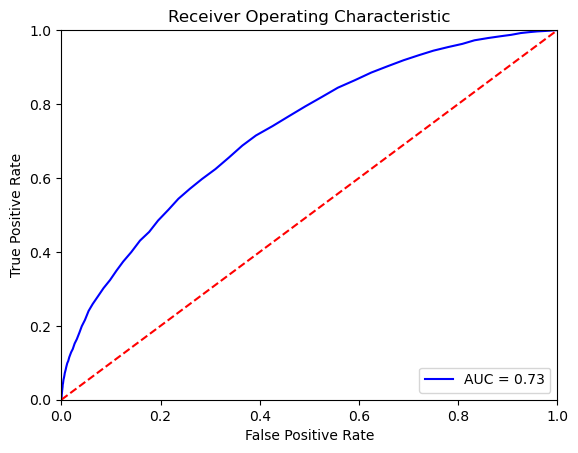

In [26]:
rf_untuned_w2v = train_randomforest(X_train_w2v, y_train_w2v)
evaluate_model(rf_untuned_w2v, X_test_w2v, y_test_w2v)
add_to_eval_df(rf_untuned_w2v, "RandomForest", "untuned", "w2v", X_train_w2v, y_train_w2v, X_test_w2v, y_test_w2v)

model accuracy for classification is = 78.83%
------------------------------------------------
Confusion Matrix:
       0   1
0  14858  14
1   3987  44
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.79      1.00      0.88     14872
           1       0.76      0.01      0.02      4031

    accuracy                           0.79     18903
   macro avg       0.77      0.50      0.45     18903
weighted avg       0.78      0.79      0.70     18903



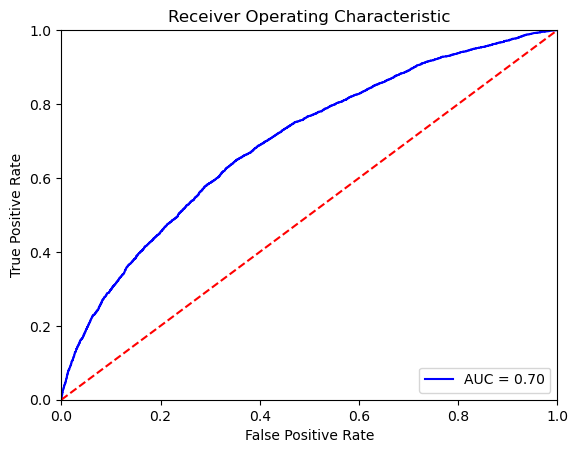

In [27]:
rf_rand_w2v = train_randomforest_tuned_randsearch(X_train_w2v, y_train_w2v)
evaluate_model(rf_rand_w2v, X_test_w2v, y_test_w2v)
add_to_eval_df(rf_rand_w2v, "RandomForest", "randsearch", "w2v", X_train_w2v, y_train_w2v, X_test_w2v, y_test_w2v)

model accuracy for classification is = 80.01%
------------------------------------------------
Confusion Matrix:
       0    1
0  14707  165
1   3613  418
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.99      0.89     14872
           1       0.72      0.10      0.18      4031

    accuracy                           0.80     18903
   macro avg       0.76      0.55      0.53     18903
weighted avg       0.78      0.80      0.74     18903



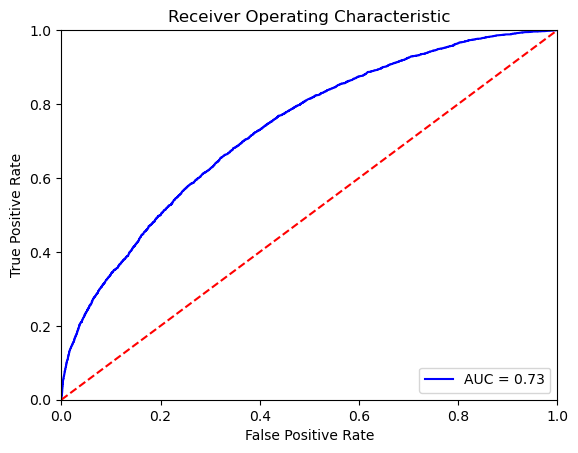

In [28]:
rf_optuna_w2v = train_randomforest_tuned_optuna(X_train_w2v, y_train_w2v)
evaluate_model(rf_optuna_w2v, X_test_w2v, y_test_w2v)
add_to_eval_df(rf_optuna_w2v, "RandomForest", "optuna", "w2v", X_train_w2v, y_train_w2v, X_test_w2v, y_test_w2v)

C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.u

model accuracy for classification is = 70.11%
------------------------------------------------
Confusion Matrix:
       0     1
0  10550  4322
1   1329  2702
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.71      0.79     14872
           1       0.38      0.67      0.49      4031

    accuracy                           0.70     18903
   macro avg       0.64      0.69      0.64     18903
weighted avg       0.78      0.70      0.72     18903



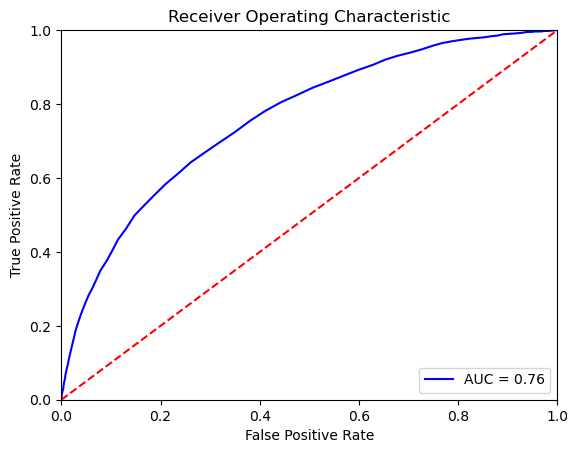

In [29]:
brf_untuned_w2v = train_balancedrandomforest(X_train_w2v, y_train_w2v)
evaluate_model(brf_untuned_w2v, X_test_w2v, y_test_w2v)
add_to_eval_df(brf_untuned_w2v, "BalancedRandomForest", "untuned", "w2v", X_train_w2v, y_train_w2v, X_test_w2v,
               y_test_w2v)

model accuracy for classification is = 80.66%
------------------------------------------------
Confusion Matrix:
       0     1
0  14068   804
1   2852  1179
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.95      0.89     14872
           1       0.59      0.29      0.39      4031

    accuracy                           0.81     18903
   macro avg       0.71      0.62      0.64     18903
weighted avg       0.78      0.81      0.78     18903



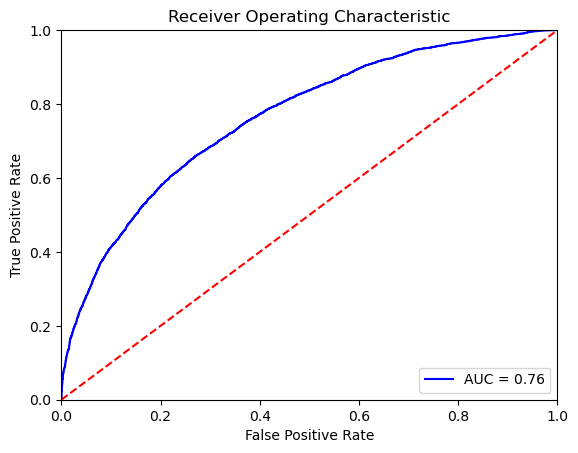

In [30]:
xgb_untuned_w2v = train_xgboost(X_train_w2v, y_train_w2v)
evaluate_model(xgb_untuned_w2v, X_test_w2v, y_test_w2v)
add_to_eval_df(xgb_untuned_w2v, "XGBoost", "untuned", "w2v", X_train_w2v, y_train_w2v, X_test_w2v, y_test_w2v)

model accuracy for classification is = 81.14%
------------------------------------------------
Confusion Matrix:
       0    1
0  14397  475
1   3090  941
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.97      0.89     14872
           1       0.66      0.23      0.35      4031

    accuracy                           0.81     18903
   macro avg       0.74      0.60      0.62     18903
weighted avg       0.79      0.81      0.77     18903



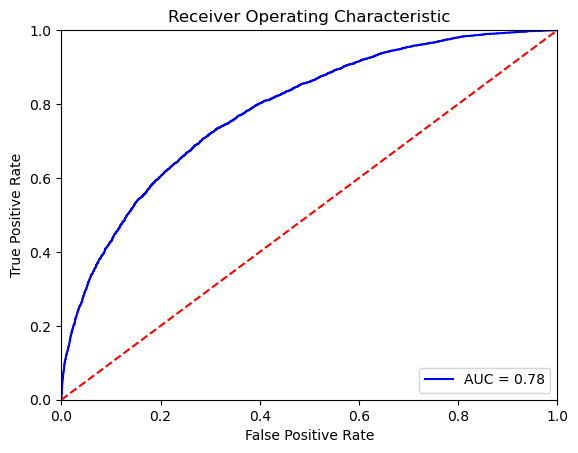

In [31]:
xgb_grid_w2v = train_xgboost_tuned_gridsearch(X_train_w2v, y_train_w2v)
evaluate_model(xgb_grid_w2v, X_test_w2v, y_test_w2v)
add_to_eval_df(xgb_grid_w2v, "XGBoost", "gridsearch", "w2v", X_train_w2v, y_train_w2v, X_test_w2v, y_test_w2v)

model accuracy for classification is = 81.09%
------------------------------------------------
Confusion Matrix:
       0     1
0  14258   614
1   2961  1070
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.96      0.89     14872
           1       0.64      0.27      0.37      4031

    accuracy                           0.81     18903
   macro avg       0.73      0.61      0.63     18903
weighted avg       0.79      0.81      0.78     18903



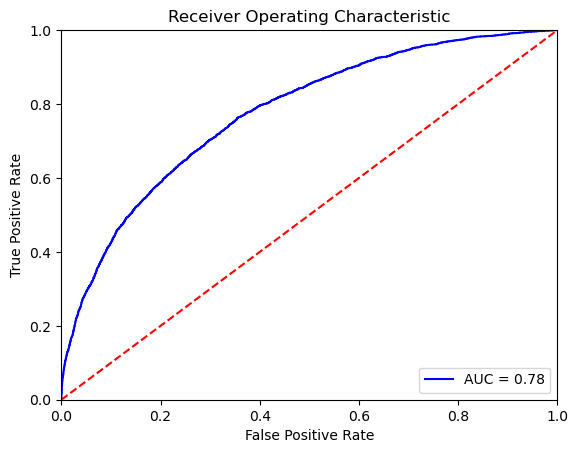

In [32]:
xgb_rand_w2v = train_xgboost_tuned_randsearch(X_train_w2v, y_train_w2v)
evaluate_model(xgb_rand_w2v, X_test_w2v, y_test_w2v)
add_to_eval_df(xgb_rand_w2v, "XGBoost", "randsearch", "w2v", X_train_w2v, y_train_w2v, X_test_w2v, y_test_w2v)

C:\Users\admin\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [21:01:16] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "boost" } are not used.

  warnings.warn(smsg, UserWarning)


model accuracy for classification is = 78.84%
------------------------------------------------
Confusion Matrix:
       0     1
0  13648  1224
1   2775  1256
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.92      0.87     14872
           1       0.51      0.31      0.39      4031

    accuracy                           0.79     18903
   macro avg       0.67      0.61      0.63     18903
weighted avg       0.76      0.79      0.77     18903



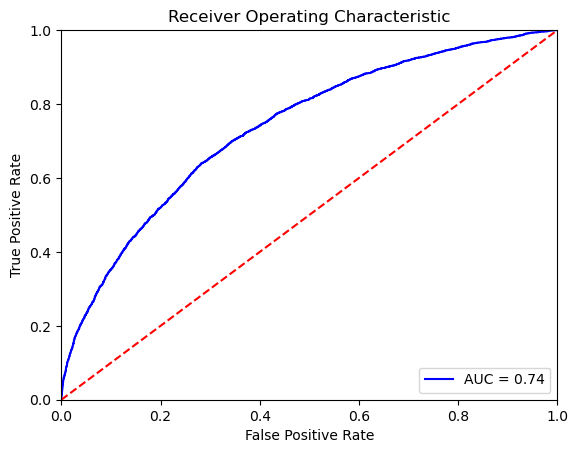

In [33]:
xgb_optuna_w2v = train_xgboost_tuned_optuna(X_train_w2v, y_train_w2v)
evaluate_model(xgb_optuna_w2v, X_test_w2v, y_test_w2v)
add_to_eval_df(xgb_optuna_w2v, "XGBoost", "optuna", "w2v", X_train_w2v, y_train_w2v, X_test_w2v, y_test_w2v)

0:	learn: 0.6537423	total: 196ms	remaining: 19.4s
1:	learn: 0.6207189	total: 263ms	remaining: 12.9s
2:	learn: 0.5946648	total: 315ms	remaining: 10.2s
3:	learn: 0.5744457	total: 371ms	remaining: 8.91s
4:	learn: 0.5569114	total: 420ms	remaining: 7.99s
5:	learn: 0.5436175	total: 476ms	remaining: 7.46s
6:	learn: 0.5317527	total: 543ms	remaining: 7.21s
7:	learn: 0.5223027	total: 602ms	remaining: 6.93s
8:	learn: 0.5142122	total: 659ms	remaining: 6.66s
9:	learn: 0.5074085	total: 720ms	remaining: 6.48s
10:	learn: 0.5014946	total: 778ms	remaining: 6.29s
11:	learn: 0.4970594	total: 840ms	remaining: 6.16s
12:	learn: 0.4929348	total: 898ms	remaining: 6.01s
13:	learn: 0.4890619	total: 965ms	remaining: 5.93s
14:	learn: 0.4860540	total: 1.02s	remaining: 5.8s
15:	learn: 0.4826955	total: 1.09s	remaining: 5.71s
16:	learn: 0.4803199	total: 1.15s	remaining: 5.61s
17:	learn: 0.4778285	total: 1.21s	remaining: 5.5s
18:	learn: 0.4758036	total: 1.27s	remaining: 5.4s
19:	learn: 0.4739896	total: 1.32s	remaining:

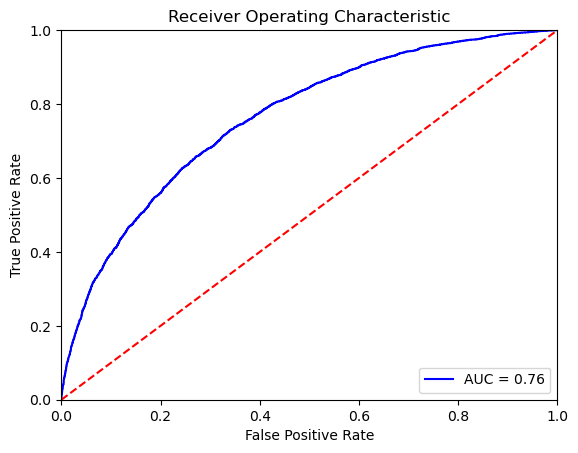

In [34]:
cat_untuned_w2v = train_catboost(X_train_w2v, y_train_w2v)
evaluate_model(cat_untuned_w2v, X_test_w2v, y_test_w2v)
add_to_eval_df(cat_untuned_w2v, "CatBoostClassifier", "untuned", "w2v", X_train_w2v, y_train_w2v, X_test_w2v,
               y_test_w2v)

[LightGBM] [Info] Number of positive: 9397, number of negative: 34708
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069822 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 76500
[LightGBM] [Info] Number of data points in the train set: 44105, number of used features: 300
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.213060 -> initscore=-1.306580
[LightGBM] [Info] Start training from score -1.306580
model accuracy for classification is = 80.89%
------------------------------------------------
Confusion Matrix:
       0    1
0  14389  483
1   3129  902
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.97      0.89     14872
           1       0.65      0.22      0.33      4031

    accuracy                           0.81     18903
   macro avg       0.74      0.60      0.61     18903
weight

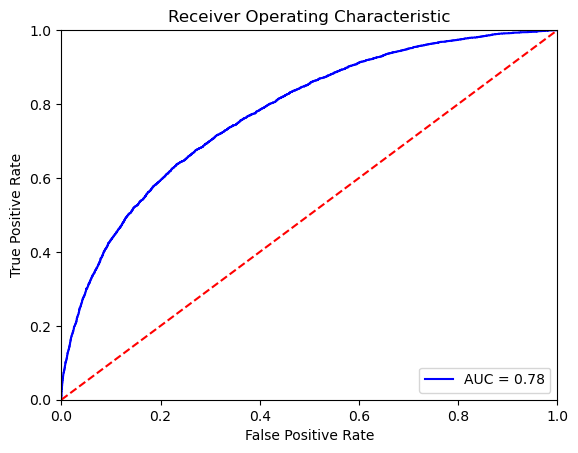

In [35]:
light_untuned_w2v = train_lightgbm(X_train_w2v, y_train_w2v)
evaluate_model(light_untuned_w2v, X_test_w2v, y_test_w2v)
add_to_eval_df(light_untuned_w2v, "LightGBM", "untuned", "w2v", X_train_w2v, y_train_w2v, X_test_w2v, y_test_w2v)

model accuracy for classification is = 80.64%
------------------------------------------------
Confusion Matrix:
       0    1
0  14325  547
1   3113  918
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.96      0.89     14872
           1       0.63      0.23      0.33      4031

    accuracy                           0.81     18903
   macro avg       0.72      0.60      0.61     18903
weighted avg       0.78      0.81      0.77     18903



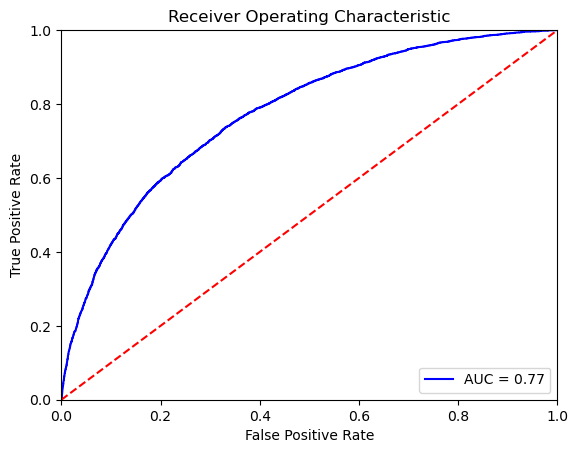

In [36]:
stack_untuned_w2v = train_stacking_rf_svm(X_train_w2v, y_train_w2v)
evaluate_model(stack_untuned_w2v, X_test_w2v, y_test_w2v)
add_to_eval_df(stack_untuned_w2v, "StackingClassifier-RF-SVC", "untuned", "w2v", X_train_w2v, y_train_w2v, X_test_w2v,
               y_test_w2v)

In [37]:
svc_untuned_w2v = train_svc(X_train_w2v, y_train_w2v)
add_to_eval_df(svc_untuned_w2v, "SVC", "untuned", "w2v", X_train_w2v, y_train_w2v, X_test_w2v, y_test_w2v)

C:\Users\admin\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


#### TF-IDF

model accuracy for classification is = 81.85%
------------------------------------------------
Confusion Matrix:
       0    1
0  14617  255
1   3176  855
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.98      0.89     14872
           1       0.77      0.21      0.33      4031

    accuracy                           0.82     18903
   macro avg       0.80      0.60      0.61     18903
weighted avg       0.81      0.82      0.78     18903



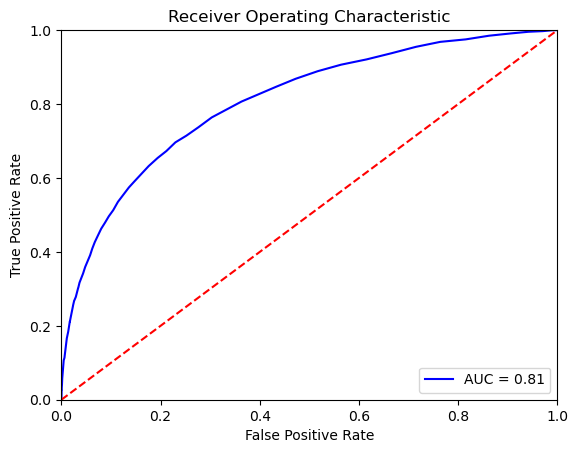

In [38]:
rf_untuned_tf = train_randomforest(X_train_tf, y_train_tf)
evaluate_model(rf_untuned_tf, X_test_tf, y_test_tf)
add_to_eval_df(rf_untuned_tf, "RandomForest", "untuned", "tf", X_train_tf, y_train_tf, X_test_tf, y_test_tf)

model accuracy for classification is = 81.19%
------------------------------------------------
Confusion Matrix:
       0    1
0  14561  311
1   3245  786
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.98      0.89     14872
           1       0.72      0.19      0.31      4031

    accuracy                           0.81     18903
   macro avg       0.77      0.59      0.60     18903
weighted avg       0.80      0.81      0.77     18903



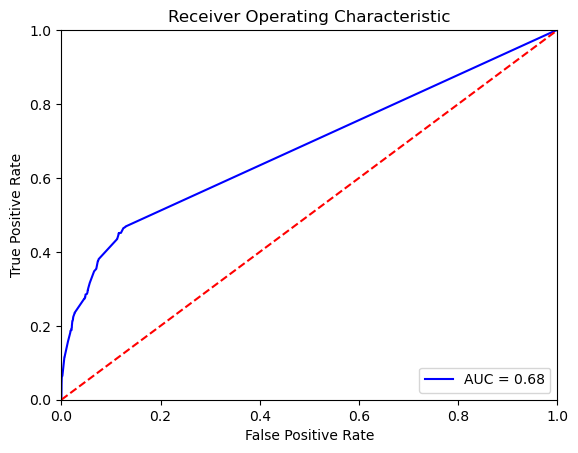

In [39]:
rf_rand_tf = train_randomforest_tuned_randsearch(X_train_tf, y_train_tf)
evaluate_model(rf_rand_tf, X_test_tf, y_test_tf)
add_to_eval_df(rf_rand_tf, "RandomForest", "randsearch", "tf", X_train_tf, y_train_tf, X_test_tf, y_test_tf)

model accuracy for classification is = 78.86%
------------------------------------------------
Confusion Matrix:
       0   1
0  14868   4
1   3992  39
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.79      1.00      0.88     14872
           1       0.91      0.01      0.02      4031

    accuracy                           0.79     18903
   macro avg       0.85      0.50      0.45     18903
weighted avg       0.81      0.79      0.70     18903



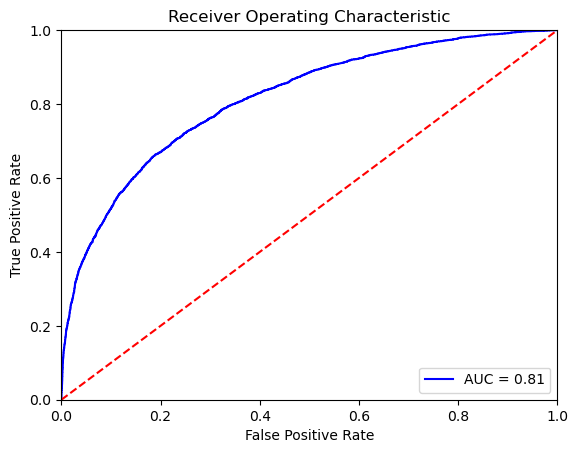

In [40]:
rf_optuna_tf = train_randomforest_tuned_optuna(X_train_tf, y_train_tf)
evaluate_model(rf_optuna_tf, X_test_tf, y_test_tf)
add_to_eval_df(rf_optuna_tf, "RandomForest", "optuna", "tf", X_train_tf, y_train_tf, X_test_tf, y_test_tf)

C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.u

model accuracy for classification is = 75.10%
------------------------------------------------
Confusion Matrix:
       0     1
0  11442  3430
1   1277  2754
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.77      0.83     14872
           1       0.45      0.68      0.54      4031

    accuracy                           0.75     18903
   macro avg       0.67      0.73      0.68     18903
weighted avg       0.80      0.75      0.77     18903



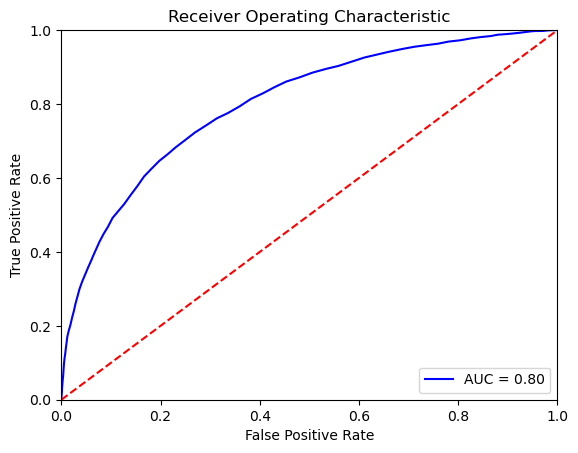

In [41]:
brf_untuned_tf = train_balancedrandomforest(X_train_tf, y_train_tf)
evaluate_model(brf_untuned_tf, X_test_tf, y_test_tf)
add_to_eval_df(brf_untuned_tf, "BalancedRandomForest", "untuned", "tf", X_train_tf, y_train_tf, X_test_tf, y_test_tf)

model accuracy for classification is = 82.92%
------------------------------------------------
Confusion Matrix:
       0     1
0  14366   506
1   2723  1308
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.97      0.90     14872
           1       0.72      0.32      0.45      4031

    accuracy                           0.83     18903
   macro avg       0.78      0.65      0.67     18903
weighted avg       0.82      0.83      0.80     18903



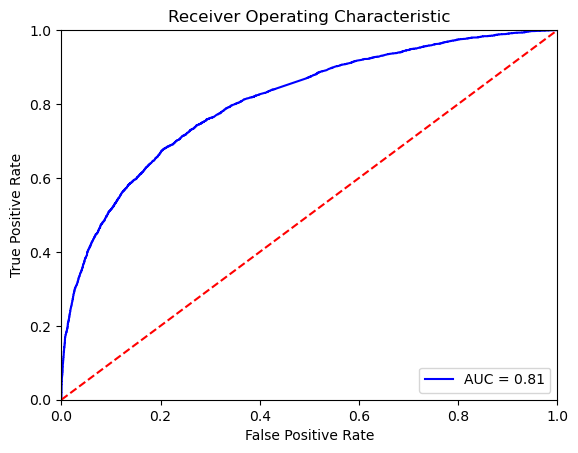

In [42]:
xgb_untuned_tf = train_xgboost(X_train_tf, y_train_tf)
evaluate_model(xgb_untuned_tf, X_test_tf, y_test_tf)
add_to_eval_df(xgb_untuned_tf, "XGBoost", "untuned", "tf", X_train_tf, y_train_tf, X_test_tf, y_test_tf)

model accuracy for classification is = 83.26%
------------------------------------------------
Confusion Matrix:
       0     1
0  14329   543
1   2621  1410
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.96      0.90     14872
           1       0.72      0.35      0.47      4031

    accuracy                           0.83     18903
   macro avg       0.78      0.66      0.69     18903
weighted avg       0.82      0.83      0.81     18903



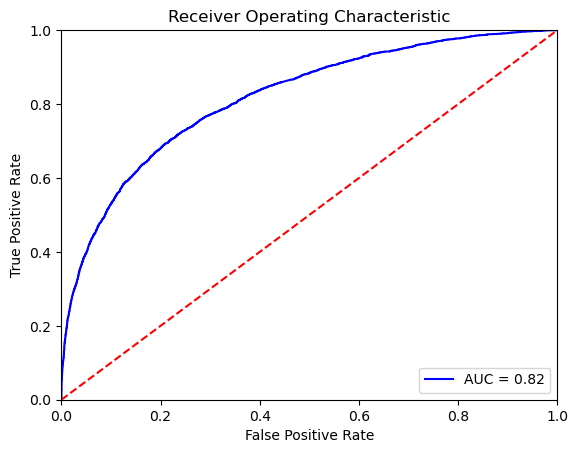

In [43]:
xgb_grid_tf = train_xgboost_tuned_gridsearch(X_train_tf, y_train_tf)
evaluate_model(xgb_grid_tf, X_test_tf, y_test_tf)
add_to_eval_df(xgb_grid_tf, "XGBoost", "gridsearch", "tf", X_train_tf, y_train_tf, X_test_tf, y_test_tf)

model accuracy for classification is = 82.89%
------------------------------------------------
Confusion Matrix:
       0     1
0  14444   428
1   2806  1225
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.97      0.90     14872
           1       0.74      0.30      0.43      4031

    accuracy                           0.83     18903
   macro avg       0.79      0.64      0.67     18903
weighted avg       0.82      0.83      0.80     18903



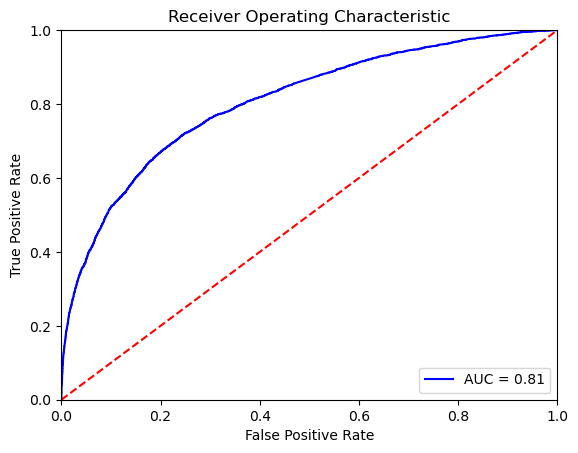

In [44]:
xgb_rand_tf = train_xgboost_tuned_randsearch(X_train_tf, y_train_tf)
evaluate_model(xgb_rand_tf, X_test_tf, y_test_tf)
add_to_eval_df(xgb_rand_tf, "XGBoost", "randsearch", "tf", X_train_tf, y_train_tf, X_test_tf, y_test_tf)

C:\Users\admin\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [21:13:34] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "boost" } are not used.

  warnings.warn(smsg, UserWarning)


model accuracy for classification is = 82.83%
------------------------------------------------
Confusion Matrix:
       0     1
0  14278   594
1   2651  1380
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.96      0.90     14872
           1       0.70      0.34      0.46      4031

    accuracy                           0.83     18903
   macro avg       0.77      0.65      0.68     18903
weighted avg       0.81      0.83      0.80     18903



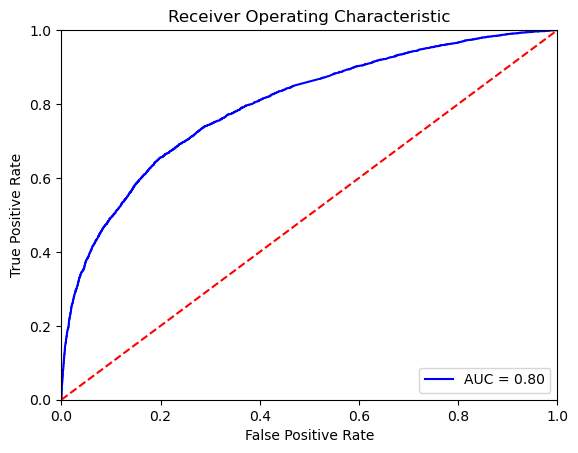

In [45]:
xgb_optuna_tf = train_xgboost_tuned_optuna(X_train_tf, y_train_tf)
evaluate_model(xgb_optuna_tf, X_test_tf, y_test_tf)
add_to_eval_df(xgb_optuna_tf, "XGBoost", "optuna", "tf", X_train_tf, y_train_tf, X_test_tf, y_test_tf)

0:	learn: 0.6526974	total: 198ms	remaining: 19.6s
1:	learn: 0.6222611	total: 383ms	remaining: 18.7s
2:	learn: 0.5969924	total: 574ms	remaining: 18.6s
3:	learn: 0.5756463	total: 761ms	remaining: 18.3s
4:	learn: 0.5578639	total: 944ms	remaining: 17.9s
5:	learn: 0.5444459	total: 1.13s	remaining: 17.8s
6:	learn: 0.5330544	total: 1.32s	remaining: 17.5s
7:	learn: 0.5232980	total: 1.51s	remaining: 17.3s
8:	learn: 0.5146851	total: 1.7s	remaining: 17.2s
9:	learn: 0.5084863	total: 1.88s	remaining: 16.9s
10:	learn: 0.5036993	total: 2.07s	remaining: 16.7s
11:	learn: 0.4993881	total: 2.25s	remaining: 16.5s
12:	learn: 0.4952681	total: 2.44s	remaining: 16.3s
13:	learn: 0.4908028	total: 2.62s	remaining: 16.1s
14:	learn: 0.4873107	total: 2.81s	remaining: 16s
15:	learn: 0.4846070	total: 3s	remaining: 15.8s
16:	learn: 0.4818883	total: 3.18s	remaining: 15.5s
17:	learn: 0.4796619	total: 3.36s	remaining: 15.3s
18:	learn: 0.4772700	total: 3.56s	remaining: 15.2s
19:	learn: 0.4753167	total: 3.73s	remaining: 14

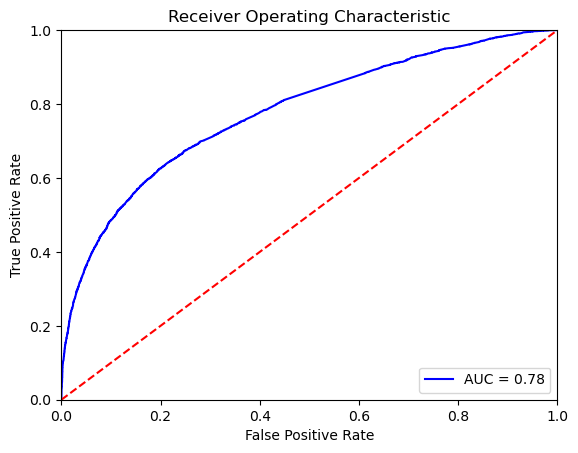

In [46]:
cat_untuned_tf = train_catboost(X_train_tf, y_train_tf)
evaluate_model(cat_untuned_tf, X_test_tf, y_test_tf)
add_to_eval_df(cat_untuned_tf, "CatBoostClassifier", "untuned", "tf", X_train_tf, y_train_tf, X_test_tf, y_test_tf)

[LightGBM] [Info] Number of positive: 9397, number of negative: 34708
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.205149 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 135163
[LightGBM] [Info] Number of data points in the train set: 44105, number of used features: 3308
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.213060 -> initscore=-1.306580
[LightGBM] [Info] Start training from score -1.306580
model accuracy for classification is = 83.14%
------------------------------------------------
Confusion Matrix:
       0     1
0  14390   482
1   2705  1326
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.97      0.90     14872
           1       0.73      0.33      0.45      4031

    accuracy                           0.83     18903
   macro avg       0.79      0.65      0.68     18903
w

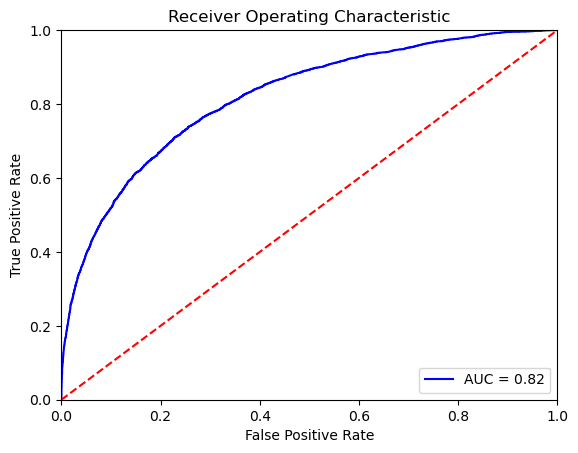

In [47]:
light_untuned_tf = train_lightgbm(X_train_tf, y_train_tf)
evaluate_model(light_untuned_tf, X_test_tf, y_test_tf)
add_to_eval_df(light_untuned_tf, "LightGBM", "untuned", "tf", X_train_tf, y_train_tf, X_test_tf, y_test_tf)

model accuracy for classification is = 83.18%
------------------------------------------------
Confusion Matrix:
       0     1
0  14234   638
1   2542  1489
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.96      0.90     14872
           1       0.70      0.37      0.48      4031

    accuracy                           0.83     18903
   macro avg       0.77      0.66      0.69     18903
weighted avg       0.82      0.83      0.81     18903



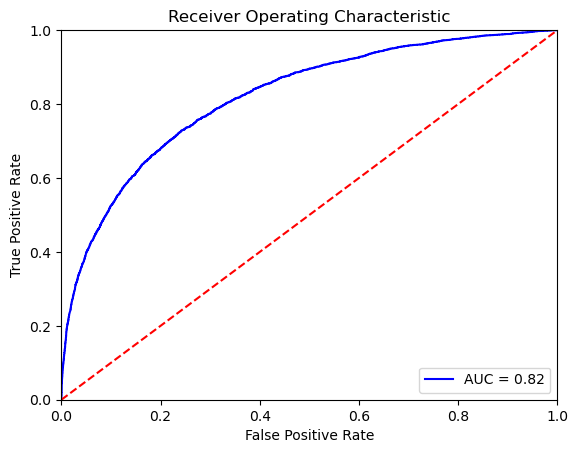

In [48]:
stack_untuned_tf = train_stacking_rf_svm(X_train_tf, y_train_tf)
evaluate_model(stack_untuned_tf, X_test_tf, y_test_tf)
add_to_eval_df(stack_untuned_tf, "StackingClassifier-RF-SVC", "untuned", "tf", X_train_tf, y_train_tf, X_test_tf,
               y_test_tf)

In [49]:
svc_untuned_tf = train_svc(X_train_tf, y_train_tf)
add_to_eval_df(svc_untuned_tf, "SVC", "untuned", "tf", X_train_tf, y_train_tf, X_test_tf, y_test_tf)

#### Glove100d

model accuracy for classification is = 79.75%
------------------------------------------------
Confusion Matrix:
       0    1
0  14724  148
1   3679  352
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.99      0.88     14872
           1       0.70      0.09      0.16      4031

    accuracy                           0.80     18903
   macro avg       0.75      0.54      0.52     18903
weighted avg       0.78      0.80      0.73     18903



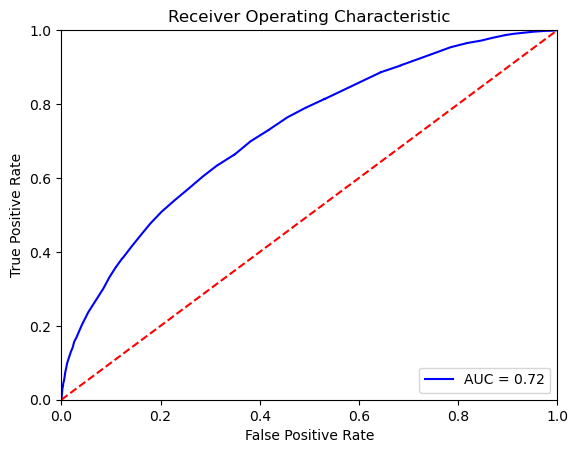

In [50]:
rf_untuned_gl = train_randomforest(X_train_gl, y_train_gl)
evaluate_model(rf_untuned_gl, X_test_gl, y_test_gl)
add_to_eval_df(rf_untuned_gl, "RandomForest", "untuned", "glove", X_train_gl, y_train_gl, X_test_gl, y_test_gl)

model accuracy for classification is = 78.86%
------------------------------------------------
Confusion Matrix:
       0   1
0  14855  17
1   3979  52
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.79      1.00      0.88     14872
           1       0.75      0.01      0.03      4031

    accuracy                           0.79     18903
   macro avg       0.77      0.51      0.45     18903
weighted avg       0.78      0.79      0.70     18903



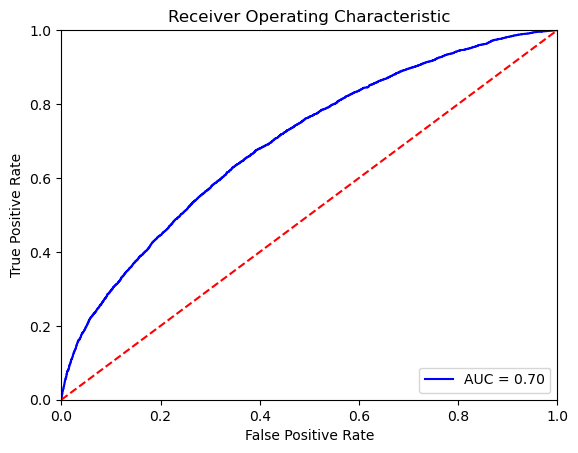

In [51]:
rf_rand_gl = train_randomforest_tuned_randsearch(X_train_gl, y_train_gl)
evaluate_model(rf_rand_gl, X_test_gl, y_test_gl)
add_to_eval_df(rf_rand_gl, "RandomForest", "randsearch", "glove", X_train_gl, y_train_gl, X_test_gl, y_test_gl)

model accuracy for classification is = 79.88%
------------------------------------------------
Confusion Matrix:
       0    1
0  14763  109
1   3694  337
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.99      0.89     14872
           1       0.76      0.08      0.15      4031

    accuracy                           0.80     18903
   macro avg       0.78      0.54      0.52     18903
weighted avg       0.79      0.80      0.73     18903



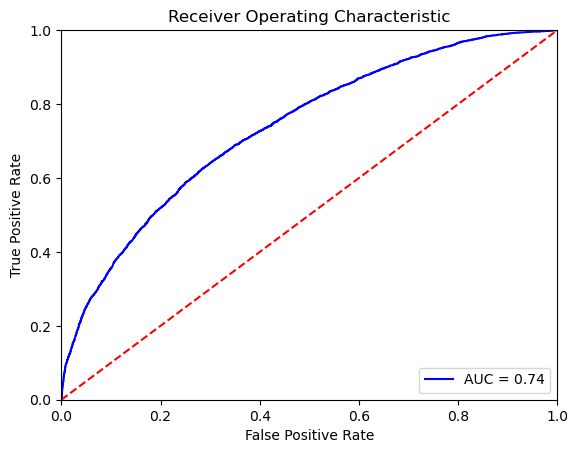

In [52]:
rf_optuna_gl = train_randomforest_tuned_optuna(X_train_gl, y_train_gl)
evaluate_model(rf_optuna_gl, X_test_gl, y_test_gl)
add_to_eval_df(rf_optuna_gl, "RandomForest", "optuna", "glove", X_train_gl, y_train_gl, X_test_gl, y_test_gl)

C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.u

model accuracy for classification is = 70.22%
------------------------------------------------
Confusion Matrix:
       0     1
0  10633  4239
1   1391  2640
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.71      0.79     14872
           1       0.38      0.65      0.48      4031

    accuracy                           0.70     18903
   macro avg       0.63      0.68      0.64     18903
weighted avg       0.78      0.70      0.73     18903



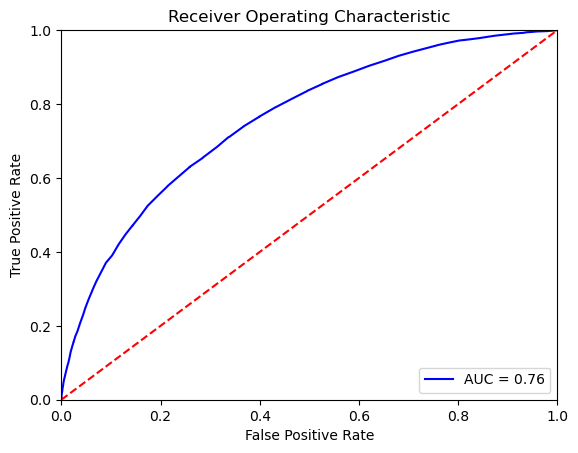

In [53]:
brf_untuned_gl = train_balancedrandomforest(X_train_gl, y_train_gl)
evaluate_model(brf_untuned_gl, X_test_gl, y_test_gl)
add_to_eval_df(brf_untuned_gl, "BalancedRandomForest", "untuned", "glove", X_train_gl, y_train_gl, X_test_gl, y_test_gl)

model accuracy for classification is = 80.11%
------------------------------------------------
Confusion Matrix:
       0     1
0  14056   816
1   2943  1088
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.95      0.88     14872
           1       0.57      0.27      0.37      4031

    accuracy                           0.80     18903
   macro avg       0.70      0.61      0.62     18903
weighted avg       0.77      0.80      0.77     18903



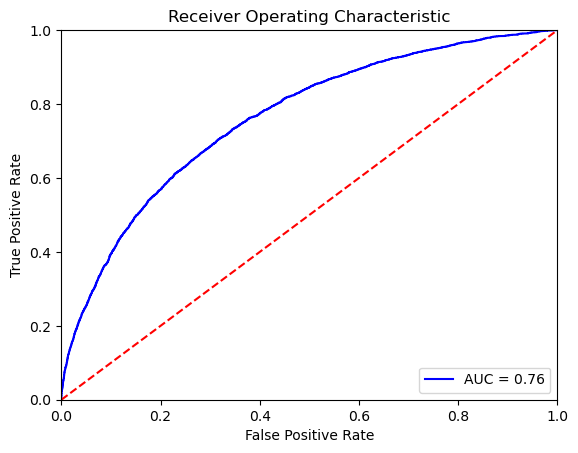

In [54]:
xgb_untuned_gl = train_xgboost(X_train_gl, y_train_gl)
evaluate_model(xgb_untuned_gl, X_test_gl, y_test_gl)
add_to_eval_df(xgb_untuned_gl, "XGBoost", "untuned", "glove", X_train_gl, y_train_gl, X_test_gl, y_test_gl)

model accuracy for classification is = 80.81%
------------------------------------------------
Confusion Matrix:
       0    1
0  14362  510
1   3117  914
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.97      0.89     14872
           1       0.64      0.23      0.34      4031

    accuracy                           0.81     18903
   macro avg       0.73      0.60      0.61     18903
weighted avg       0.78      0.81      0.77     18903



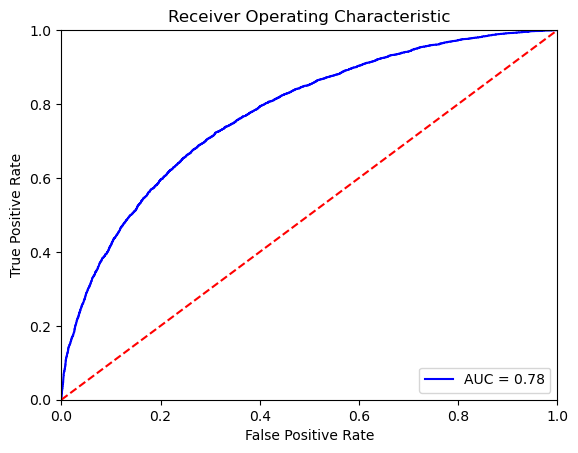

In [55]:
xgb_grid_gl = train_xgboost_tuned_gridsearch(X_train_gl, y_train_gl)
evaluate_model(xgb_grid_gl, X_test_gl, y_test_gl)
add_to_eval_df(xgb_grid_gl, "XGBoost", "gridsearch", "glove", X_train_gl, y_train_gl, X_test_gl, y_test_gl)

model accuracy for classification is = 80.82%
------------------------------------------------
Confusion Matrix:
       0     1
0  14232   640
1   2985  1046
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.96      0.89     14872
           1       0.62      0.26      0.37      4031

    accuracy                           0.81     18903
   macro avg       0.72      0.61      0.63     18903
weighted avg       0.78      0.81      0.78     18903



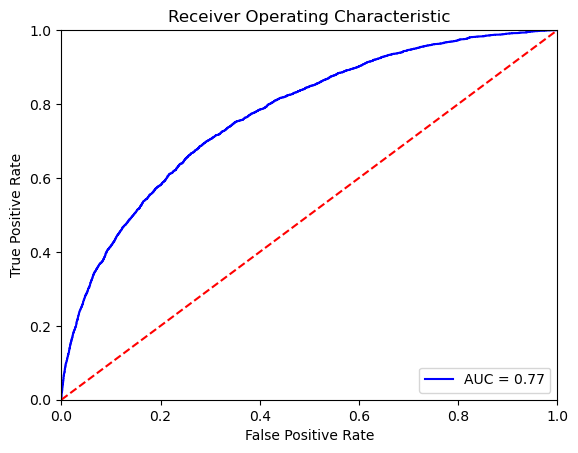

In [56]:
xgb_rand_gl = train_xgboost_tuned_randsearch(X_train_gl, y_train_gl)
evaluate_model(xgb_rand_gl, X_test_gl, y_test_gl)
add_to_eval_df(xgb_rand_gl, "XGBoost", "randsearch", "glove", X_train_gl, y_train_gl, X_test_gl, y_test_gl)

C:\Users\admin\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [21:27:10] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "boost" } are not used.

  warnings.warn(smsg, UserWarning)


model accuracy for classification is = 79.48%
------------------------------------------------
Confusion Matrix:
       0     1
0  13806  1066
1   2812  1219
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.93      0.88     14872
           1       0.53      0.30      0.39      4031

    accuracy                           0.79     18903
   macro avg       0.68      0.62      0.63     18903
weighted avg       0.77      0.79      0.77     18903



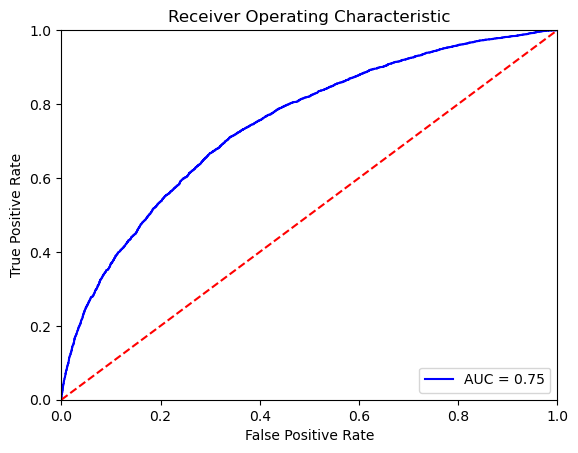

In [57]:
xgb_optuna_gl = train_xgboost_tuned_optuna(X_train_gl, y_train_gl)
evaluate_model(xgb_optuna_gl, X_test_gl, y_test_gl)
add_to_eval_df(xgb_optuna_gl, "XGBoost", "optuna", "glove", X_train_gl, y_train_gl, X_test_gl, y_test_gl)

0:	learn: 0.6551811	total: 28.9ms	remaining: 2.86s
1:	learn: 0.6246406	total: 56.8ms	remaining: 2.78s
2:	learn: 0.5979356	total: 86.1ms	remaining: 2.78s
3:	learn: 0.5769077	total: 115ms	remaining: 2.76s
4:	learn: 0.5592476	total: 144ms	remaining: 2.73s
5:	learn: 0.5455962	total: 171ms	remaining: 2.67s
6:	learn: 0.5344145	total: 199ms	remaining: 2.64s
7:	learn: 0.5257434	total: 228ms	remaining: 2.62s
8:	learn: 0.5178495	total: 258ms	remaining: 2.61s
9:	learn: 0.5112000	total: 286ms	remaining: 2.58s
10:	learn: 0.5056828	total: 316ms	remaining: 2.56s
11:	learn: 0.5007843	total: 343ms	remaining: 2.52s
12:	learn: 0.4967679	total: 370ms	remaining: 2.48s
13:	learn: 0.4932465	total: 398ms	remaining: 2.45s
14:	learn: 0.4897330	total: 426ms	remaining: 2.41s
15:	learn: 0.4869127	total: 455ms	remaining: 2.39s
16:	learn: 0.4847283	total: 482ms	remaining: 2.35s
17:	learn: 0.4823653	total: 510ms	remaining: 2.33s
18:	learn: 0.4805096	total: 541ms	remaining: 2.31s
19:	learn: 0.4788451	total: 569ms	rema

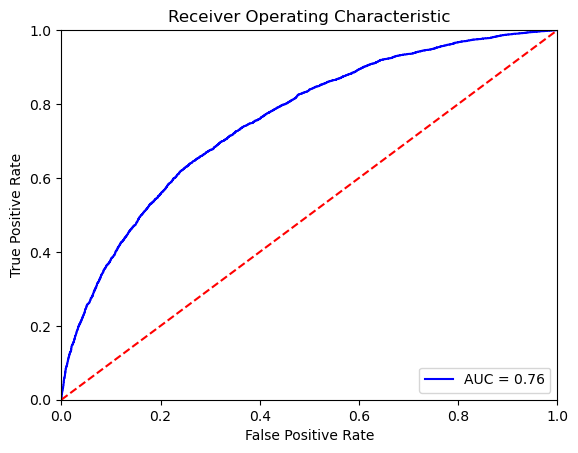

In [58]:
cat_untuned_gl = train_catboost(X_train_gl, y_train_gl)
evaluate_model(cat_untuned_gl, X_test_gl, y_test_gl)
add_to_eval_df(cat_untuned_gl, "CatBoostClassifier", "untuned", "glove", X_train_gl, y_train_gl, X_test_gl, y_test_gl)

[LightGBM] [Info] Number of positive: 9397, number of negative: 34708
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014904 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 44105, number of used features: 100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.213060 -> initscore=-1.306580
[LightGBM] [Info] Start training from score -1.306580
model accuracy for classification is = 80.80%
------------------------------------------------
Confusion Matrix:
       0    1
0  14405  467
1   3162  869
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.97      0.89     14872
           1       0.65      0.22      0.32      4031

    accuracy                           0.81     18903
   macro avg       0.74      0.59      0.61     18903
weight

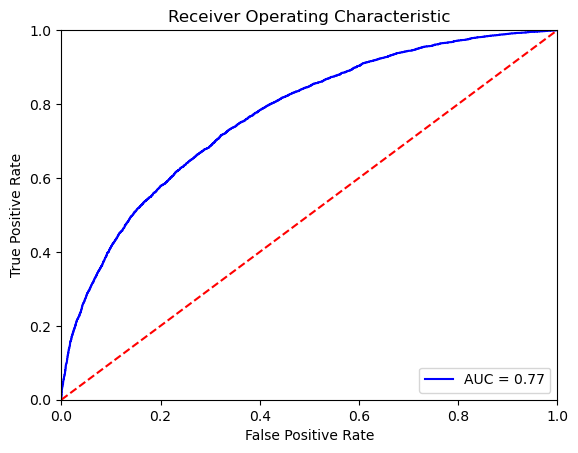

In [59]:
light_untuned_gl = train_lightgbm(X_train_gl, y_train_gl)
evaluate_model(light_untuned_gl, X_test_gl, y_test_gl)
add_to_eval_df(light_untuned_gl, "LightGBM", "untuned", "glove", X_train_gl, y_train_gl, X_test_gl, y_test_gl)

model accuracy for classification is = 80.01%
------------------------------------------------
Confusion Matrix:
       0    1
0  14433  439
1   3339  692
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.97      0.88     14872
           1       0.61      0.17      0.27      4031

    accuracy                           0.80     18903
   macro avg       0.71      0.57      0.58     18903
weighted avg       0.77      0.80      0.75     18903



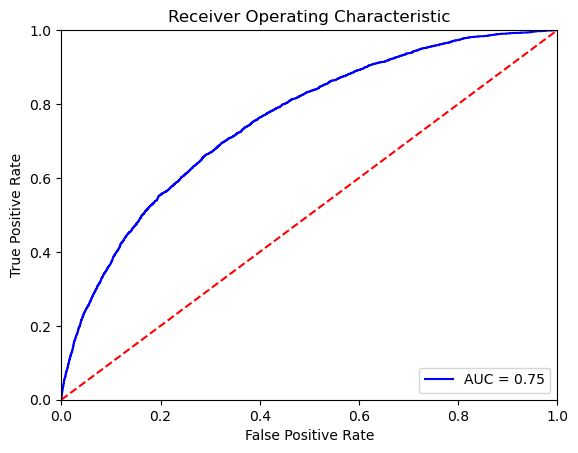

In [60]:
stack_untuned_gl = train_stacking_rf_svm(X_train_gl, y_train_gl)
evaluate_model(stack_untuned_gl, X_test_gl, y_test_gl)
add_to_eval_df(stack_untuned_gl, "StackingClassifier-RF-SVC", "untuned", "glove", X_train_gl, y_train_gl, X_test_gl,
               y_test_gl)

In [61]:
svc_untuned_gl = train_svc(X_train_gl, y_train_gl)
add_to_eval_df(svc_untuned_gl, "SVC", "untuned", "glove", X_train_gl, y_train_gl, X_test_gl, y_test_gl)

C:\Users\admin\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


### Model evaluation

In [62]:
evaluation.sort_values(by=["test_f1"], ascending=False)

,model,tuning,vec_variant,train_acc,train_prec,train_rec,train_f1,test_acc,test_prec,test_rec,test_f1
15,BalancedRandomForest,untuned,tf,0.925541,0.741030,1.000000,0.851255,0.750992,0.445343,0.683205,0.539207
3,BalancedRandomForest,untuned,w2v,0.923478,0.735750,1.000000,0.847760,0.701053,0.384681,0.670305,0.488829
23,SVC,untuned,tf,0.913048,0.894021,0.671491,0.766940,0.821245,0.629160,0.393947,0.484516
27,BalancedRandomForest,untuned,glove,0.918059,0.722474,0.999255,0.838617,0.702164,0.383777,0.654924,0.483960
22,StackingClassifier-RF-SVC,untuned,tf,0.997438,0.990905,0.997127,0.994006,0.831773,0.700047,0.369387,0.483599
17,XGBoost,gridsearch,tf,0.879764,0.906473,0.485793,0.632578,0.832619,0.721966,0.349789,0.471257
19,XGBoost,optuna,tf,0.853191,0.806546,0.409067,0.542823,0.828334,0.699088,0.342347,0.459617
21,LightGBM,untuned,tf,0.851377,0.819326,0.387996,0.526612,0.831402,0.733407,0.328951,0.454187
16,XGBoost,untuned,tf,0.860220,0.868613,0.405236,0.552645,0.829181,0.721058,0.324485,0.447562
18,XGBoost,randsearch,tf,0.846752,0.833755,0.350644,0.493670,0.828916,0.741077,0.303895,0.431034
